<a href="https://colab.research.google.com/github/CIA-Oceanix/DLGD2022/blob/main/tutorial2_TFP/tutorial_TF_Probability" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>



# Tutorial Tensorflow-probability


## Install package

In [ ]:
!pip install --upgrade tensorflow-probability==0.17.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.5 MB 7.3 MB/s 
  Attempting uninstall: tensorflow-probability
    Found existing installation: tensorflow-probability 0.18.0
    Uninstalling tensorflow-probability-0.18.0:
      Successfully uninstalled tensorflow-probability-0.18.0


### Import packages

In [1]:
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()

import tensorflow_probability as tfp

sns.reset_defaults()
sns.set_context(context='talk',font_scale=0.7)
plt.rcParams['image.cmap'] = 'viridis'

%matplotlib inline

tfk  = tf.keras
tfkl = tf.keras.layers
tfd  = tfp.distributions
tfb  = tfp.bijectors
tfpl = tfp.layers


## Utils

In [8]:
def print_subclasses_from_module(module, base_class, maxwidth=80):
  import functools, inspect, sys
  subclasses = [name for name, obj in inspect.getmembers(module)
                if inspect.isclass(obj) and issubclass(obj, base_class)]
  def red(acc, x):
    if not acc or len(acc[-1]) + len(x) + 2 > maxwidth:
      acc.append(x)
    else:
      acc[-1] += ", " + x
    return acc
  print('\n'.join(functools.reduce(red, subclasses, [])))


## Tensorflow-probability overview

Tensorflow-probability is a helpful toolbox for probabilistic machine learning.   
It is structured as follows :

- Component 0 (Core): **Tensorflow Core** for numerical operations
- Component 1 (Low-level): **Statistical Building Blocks** 
    - *Distributions* (tfp.distributions): A large collection of probability distributions and related statistics (Normal, Gamma, Pareto...).
    - *Bijectors* (tfp.bijectors): Reversible and composable transformations of random variables. Bijectors provide a rich class of transformed distributions.
- Component 2 (Higher-level): **Model Building** and **Probabilistic Inference**
    - *Joint Distributions* (e.g., tfp.distributions.JointDistributionSequential): Joint distributions over one or more possibly-interdependent distributions.
    - *Probabilistic layers* (tfp.layers): Neural network layers which ouput tfp.distribution type objects.
    - *Monte-Carlo Markov Chain* (tfp.mcmc).
    - *Variational inference* (tfp.vi).
    - *Optimizers* (tfp.optimizers)







## Distributions in Tensorflow-probability

A tfp.distributions.Distribution is a class with two core methods: sample and log_prob. It may additionally have many other methods : entropy, kl_divergence, cdf, mean, mode, prob, cdf, log_cdf…



In [9]:
# TFP has a lot of distributions!
print_subclasses_from_module(tfp.distributions, tfp.distributions.Distribution)


Autoregressive, BatchBroadcast, BatchConcat, BatchReshape, Bates, Bernoulli
Beta, BetaBinomial, BetaQuotient, Binomial, Blockwise, Categorical, Cauchy, Chi
Chi2, CholeskyLKJ, ContinuousBernoulli, DeterminantalPointProcess, Deterministic
Dirichlet, DirichletMultinomial, Distribution, DoublesidedMaxwell, Empirical
ExpGamma, ExpInverseGamma, ExpRelaxedOneHotCategorical, Exponential
ExponentiallyModifiedGaussian, FiniteDiscrete, Gamma, GammaGamma
GaussianProcess, GaussianProcessRegressionModel, GeneralizedExtremeValue
GeneralizedNormal, GeneralizedPareto, Geometric, Gumbel, HalfCauchy, HalfNormal
HalfStudentT, HiddenMarkovModel, Horseshoe, Independent, InverseGamma
InverseGaussian, JohnsonSU, JointDistribution, JointDistributionCoroutine
JointDistributionCoroutineAutoBatched, JointDistributionNamed
JointDistributionNamedAutoBatched, JointDistributionSequential
JointDistributionSequentialAutoBatched, Kumaraswamy, LKJ, LambertWDistribution
LambertWNormal, Laplace, LinearGaussianStateSpaceMod

tfp.distributions.Normal("Normal", batch_shape=[], event_shape=[], dtype=float32)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


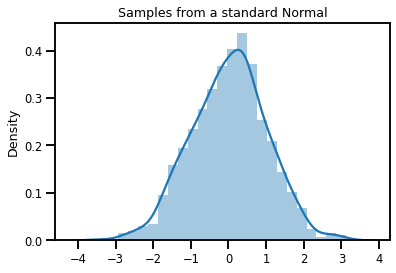

In [10]:
# A standard normal
normal = tfd.Normal(loc=0., scale=1.)
print(normal)
# Plot 1000 samples from a standard normal
samples = normal.sample(1000)
sns.distplot(samples)
plt.title("Samples from a standard Normal")
plt.show()


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


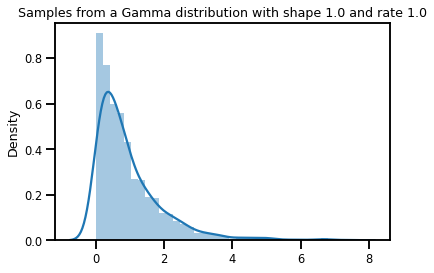

In [15]:
# A Gamma distribution
c = 1.
r = 1.
gamma = tfd.Gamma(concentration=c, rate=r)

# Plot 1000 samples 
samples = gamma.sample(1000)
sns.distplot(samples)
plt.title(f"Samples from a Gamma distribution with shape {c} and rate {r}")
plt.show()

### Play around

- Sample a tensor of shape $128\times 128 \times 3 $ from the standard normal.
- Calculate the log probabilities of each sample with the method log_prob.
- Calculate the exact KL divergence between the standard normal and a gaussian distribution with $\mu = 1$ and $\sigma = 2$ using the method kl_divergence.
- What happen if you try to calculate the KL divergence between the standard normal and the previously defined gamma distribution?
- Using the Monte Carlo estimator of KL divergence code (cell hereafter), calculate an approximation of the KL divergence between the Gamma distribution and the standard normal.

In [26]:
def approx_kl(p,q,num_draws = int(1e5)):
  return(tfp.monte_carlo.expectation(
    f=lambda x: p.log_prob(x) - q.log_prob(x),
    samples=p.sample(num_draws, seed=42),
    log_prob=p.log_prob,
    use_reparameterization=(p.reparameterization_type
                           == tfp.distributions.FULLY_REPARAMETERIZED)))


## Bijectors

Bijectors represent invertible, smooth functions. They can be used to transform distributions.

In other words, $X$ is a random variable with pdf $p$, and $g$ is a smooth invertible function on the space of $X$'s, then the new random variable $Y = g(X)$ is s.t:
\begin{equation}
P(Y=y) = P\left(X=g^{-1}(y)\right).|\nabla g^{-1}(y)|
\end{equation}

With *tfp.bijectors*, it preserves the ability to take samples and compute log probabilities when appying a invertible transformation to a distribution.

In [58]:
#Many bijectors available
print_subclasses_from_module(tfb, tfb.Bijector)


AbsoluteValue, Ascending, AutoCompositeTensorBijector, BatchNormalization
Bijector, Blockwise, Chain, CholeskyOuterProduct, CholeskyToInvCholesky
Composition, CorrelationCholesky, Cumsum, DiscreteCosineTransform, Exp, Expm1
FFJORD, FillScaleTriL, FillTriangular, FrechetCDF, GeneralizedExtremeValueCDF
GeneralizedPareto, Glow, GompertzCDF, GumbelCDF, Householder, Identity, Inline
Invert, IteratedSigmoidCentered, JointMap, KumaraswamyCDF, LambertWTail, Log
Log1p, MaskedAutoregressiveFlow, MatrixInverseTriL, MatvecLU, MoyalCDF
NormalCDF, Pad, Permute, Power, PowerTransform, RationalQuadraticSpline
RayleighCDF, RealNVP, Reciprocal, Reshape, Restructure, Scale, ScaleMatvecDiag
ScaleMatvecLU, ScaleMatvecLinearOperator, ScaleMatvecLinearOperatorBlock
ScaleMatvecTriL, Shift, ShiftedGompertzCDF, Sigmoid, Sinh, SinhArcsinh, SoftClip
Softfloor, SoftmaxCentered, Softplus, Softsign, Split, Square, Tanh
TransformDiagonal, Transpose, WeibullCDF


### Example with the NormalCDF transformation

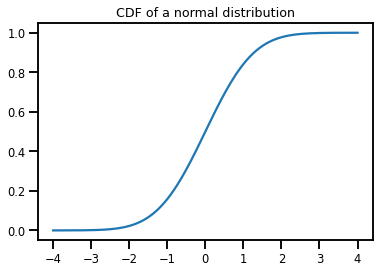

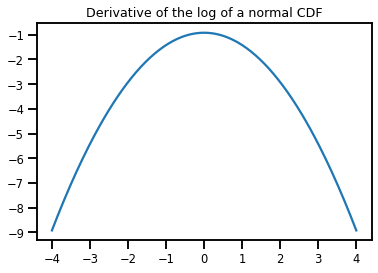

In [31]:
normal_cdf = tfb.NormalCDF()
xs = np.linspace(-4., 4., 200)
plt.plot(xs, normal_cdf.forward(xs))
plt.title("CDF of a normal distribution")
plt.show()
plt.figure()
plt.title("Log of the derivative of a normal CDF")
plt.plot(xs, normal_cdf.forward_log_det_jacobian(xs, event_ndims=0))
plt.show()


### Transforming a distribution with a bijector

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


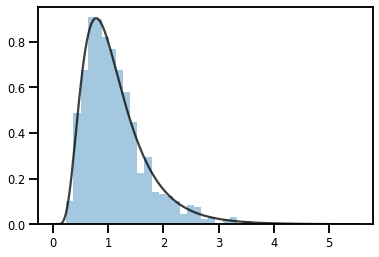

In [32]:
#From Normal distribution to logNormal
exp_bijector = tfb.Exp()
log_normal = exp_bijector(tfd.Normal(0., .5))

samples = log_normal.sample(1000)
xs = np.linspace(1e-10, np.max(samples), 200)
sns.distplot(samples, norm_hist=True, kde=False)
plt.plot(xs, log_normal.prob(xs), c='k', alpha=.75)
plt.show()


### Play around

- Using a standard normal distribution and the NormalCDF bijector, sample from a uniform distribution.
- Using a uniform distribution and the NormalCDF bijector, sample from a standard normal distribution.

## Learnable distribution

In this section we create a probabilistic model and fit the data by minimizing the negative log likelihood criterion.

In [6]:
# ML criterion
neg_log_likelihood = lambda x,rvx : -rvx.log_prob(x)

In [7]:
# Generate the dataset
w0 = 0.125
b0 = 5.
x_range = [-20, 60]

def load_dataset(n=150, n_tst=150):
  np.random.seed(43)
  def s(x):
    g = (x - x_range[0]) / (x_range[1] - x_range[0])
    return 3 * (0.25 + g**2.)
  x = (x_range[1] - x_range[0]) * np.random.rand(n) + x_range[0]
  eps = np.random.randn(n) * s(x)
  y = (w0 * x * (1. + np.sin(x)) + b0) + eps
  x = x[..., np.newaxis]
  x_tst = np.linspace(*x_range, num=n_tst).astype(np.float32)
  x_tst = x_tst[..., np.newaxis]
  return y, x, x_tst

y, x, x_tst = load_dataset()


We create a basic gaussian probabilistic model with $\mu$ an affine function of $x$ and $\sigma=1$.

---



In [52]:
# Build model.
model = tf.keras.Sequential([
  tf.keras.layers.Dense(1),
  tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)),
])

# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=neg_log_likelihood)
model.fit(x, y, epochs=1000, verbose=False)

# Return weight and bias
[print(np.squeeze(w.numpy())) for w in model.weights];
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)


0.1392466
5.1429625


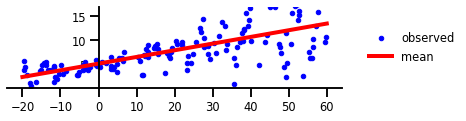

In [53]:
# Plot 

w = np.squeeze(model.layers[-2].kernel.numpy())
b = np.squeeze(model.layers[-2].bias.numpy())

plt.figure(figsize=[6, 1.5])  # inches
#plt.figure(figsize=[8, 5])  # inches
plt.plot(x, y, 'b.', label='observed');
plt.plot(x_tst, yhat.mean(),'r', label='mean', linewidth=4);
plt.ylim(-0.,17);
plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));

ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['left'].set_smart_bounds(True)
#ax.spines['bottom'].set_smart_bounds(True)
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))


### Play around

- Modify the code so $\mu$ is an affine functions of $x$ and $\sigma$ is a strictly positive function of $x$. We can use the function *tf.math.softplus* and add a constant to enforce $\sigma$ to be strictly positive.
- Modify the code to transform the output distribution in a Generalized Normal distribution with learnable mean, standard deviation and power.
-  The module *tfpl.DenseVariational(units, make_posterior, make_prior)* implements the Bayesian variational inference analogue to
  a dense layer by assuming the kernel and/or the bias are drawn
  from distributions. In this context :
  - *units* stand for the size of the ouput space.
  - Let $K$ be the kernel weights and $b$ the bias. Given a prior for $K$ and $b$ and a surrogate posterior $K,b|x$, the layer adds a KL divergence loss between prior and posterior to the overall cost. 
  - The *make_prior* and *make_posterior* arguments are Python callable taking tf.size(kernel), tf.size(bias) as inputs and return another callable which takes an input and produces a tfd.Distribution ouptut.

  The cell block hereafter gives an example of a trainable normal prior over $K$ and $b$. Based on this code section build a make_posterior function which implements a surrogate normal distribution with constant mean and standard deviation parameters. Then, create a probabilistic network with the Dense Variational layer which encompasses uncertainty over the parameters of the affine function $\mu(x)$, letting $\sigma=1$.   


In [59]:
# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1)),
  ])


## Example of more complex inference model : Variational Auto-encoder

Given a set of samples from a random vector $X$, with unknown dustribution $p(x)$, the VAE is a generative method to sample from $X$ based on the minimization of a variational inference cost. In fact for any random variable $Z$ with distribution $p(z)$:
\begin{equation}
\log p(x) = - D_{KL}\left( p(z|x)||p(z) \right) + E_{z\sim p(z|x)}[p(x|z)]
\end{equation}
Using surrogate posterior $q_{\phi}$ depending on a set of parameters $\phi$, surrogate likelihood $p_\theta(x|z)$ we obtain the Evidence Lower BOund (ELBO) (right handside of the inequation):
\begin{equation}
\log p(x) \geq - D_{KL}\left( q_\phi(z|x)||p(z) \right) + E_{z\sim q_\phi(z|x)}[p_\theta(x|z)]
\end{equation}
We seek to maximize the ELBO wrt $\phi$ and $\theta$.

In [2]:
# Encoder network
class Encoder(tfk.Model):
    
    def __init__(self):      
        super(Encoder,self).__init__()
        self.encoded_size = 2
        self.prior        = tfd.Independent(tfd.Normal(loc=tf.zeros(self.encoded_size), scale=1),
                        reinterpreted_batch_ndims=1)
        self.dense1       = tfkl.Dense(5,activation='relu')
        self.dense2       = tfkl.Dense(5,activation='relu')
        self.lambda1      = tfkl.Lambda(lambda x: tf.abs(x)+0.001)
        self.dense3       = tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(self.encoded_size))
        self.multv_norm1  = tfpl.MultivariateNormalTriL(self.encoded_size,
                                                   activity_regularizer=tfpl.KLDivergenceRegularizer(self.prior,
                                                                                                     weight=1.0))
        
    def call(self, inputs):
      x = self.dense1(inputs)
      x = self.dense2(x)
      x = self.lambda1(x)
      x = self.dense3(x)
      x = self.multv_norm1(x)
      return x

In [3]:
# Decoder network
class Decoder(tfk.Model):
    def __init__(self):
        super(Decoder,self).__init__()
        self.K         = 2
        self.dense1    = tfkl.Dense(5, use_bias=True, activation='relu')
        self.dense2    = tfkl.Dense(5, use_bias=True, activation='relu')
        self.dense3    = tfkl.Dense(tfpl.MultivariateNormalTriL(self.K).params_size(self.K))        
        self.ind_norm1 = tfpl.MultivariateNormalTriL(self.K)
        
        
    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.ind_norm1(x)
        return x

In [4]:
# VAE class 
class VAE(tfk.Model):
    def __init__(self):      
        super(VAE,self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def call(self,inputs):
        return self.decoder(self.encoder(inputs))
    


In [8]:
Y  = tf.cast(tf.reshape(y,(150,1)),dtype = tf.float64)
X  = tf.cast(x,tf.float64)
sX = 40
sY = 10
Ds = tf.concat([X/sX,Y/sY],1)
vae = VAE()

In [10]:
# Training
vae.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3),
            loss=neg_log_likelihood)
vae.fit(Ds,Ds,
        batch_size=32,
        epochs=100,
        verbose =1 
        )

Epoch 1/100
5/5 [==============================] - 4s 6ms/step - loss: 3.1974
Epoch 2/100
5/5 [==============================] - 0s 4ms/step - loss: 3.0833
Epoch 3/100
5/5 [==============================] - 0s 4ms/step - loss: 3.0994
Epoch 4/100
5/5 [==============================] - 0s 3ms/step - loss: 3.0520
Epoch 5/100
5/5 [==============================] - 0s 5ms/step - loss: 2.8055
Epoch 6/100
5/5 [==============================] - 0s 4ms/step - loss: 2.9202
Epoch 7/100
5/5 [==============================] - 0s 3ms/step - loss: 2.8204
Epoch 8/100
5/5 [==============================] - 0s 4ms/step - loss: 2.7645
Epoch 9/100
5/5 [==============================] - 0s 4ms/step - loss: 2.5126
Epoch 10/100
5/5 [==============================] - 0s 5ms/step - loss: 2.4991
Epoch 11/100
5/5 [==============================] - 0s 5ms/step - loss: 2.6204
Epoch 12/100
5/5 [==============================] - 0s 5ms/step - loss: 2.5186
Epoch 13/100
5/5 [==============================] - 0s 4ms/st

(100, 2)


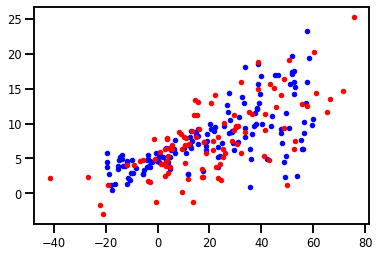

In [18]:
#plotting some samples
samples_prior = vae.encoder.prior.sample(100)
vae_samples   = vae.decoder(samples_prior).sample()
print(vae_samples.shape)
plt.figure()
plt.plot(x, y, 'b.', label='observed');
plt.plot(vae_samples[:,0]*sX,vae_samples[:,1]*sY,'r.',label='sampled')

### Play around

- Turn the VAE to a $\beta$-VAE by modifying the regularization in the encoder.
- Turn the scale of the prior learnable

## Flow architecture with Tensorflow-probability

The objective of this section is to build a flow by chaining tfp.bijectors

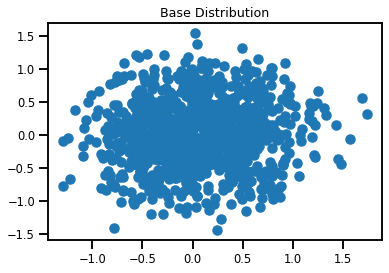

In [4]:
# Base distribution
def create_2d_gaussian(𝜇=0, 𝜎=0.5):
    return tfd.MultivariateNormalDiag(
        loc=[𝜇, 𝜇],
        scale_diag=[𝜎, 𝜎]
    )

gaussian_2d_base_dist = create_2d_gaussian()
gaussian_2d_samples = gaussian_2d_base_dist.sample(1000)
plt.scatter(gaussian_2d_samples[:, 0], gaussian_2d_samples[:, 1])
plt.title("Base Distribution")
plt.show()

In [7]:
# Defining various bijections f1 to f5

#f1 : Shift bijector
def f1(c1=0, c2=-2):
    return tfb.Shift([c1, c2])

#f2 : Scale bijector
def f2(d1=1, d2=0.5):
    return tfb.Scale([d1, d2])


#f3 : Shift and to the power 3
class ShiftAndCube(tfb.Bijector):
    def __init__(self, validate_args=False, name="Shift and Cube"):
        super(ShiftAndCube, self).__init__(
            validate_args=validate_args,
            forward_min_event_ndims=1,
            inverse_min_event_ndims=1,
            name=name,
            is_constant_jacobian=True
        )
        self.a = tfd.Normal(loc=3, scale=1).sample()

    def _forward(self, x):
        x = tf.cast(x, tf.float32)
        a = [
             [0, self.a],
             [0, 0]
        ]
        return x + tf.matmul(tf.pow(x, 3), a)


    def _inverse(self, y):
        y = tf.cast(y, tf.float32)
        a = [
             [0, self.a],
             [0, 0]
        ]
        return y - tf.matmul(tf.pow(y, 3), a)

    def _forward_log_det_jacobian(self, x):
        return tf.constant(1, dtype=tf.float32)
    
def f3():
    return ShiftAndCube()


# f4 : Rotation
class Rotation2D(tfb.Bijector):
    def __init__(self, validate_args=False, name="rotation_2d"):
        super(Rotation2D, self).__init__(
            validate_args=validate_args,
            forward_min_event_ndims=1,
            inverse_min_event_ndims=1,
            name=name,
            is_constant_jacobian=True
        )

        theta = tfd.Uniform(low=0.0, high=2*np.pi).sample()

        self.cos_theta = tf.math.cos(theta)
        self.sin_theta = tf.math.sin(theta)
        self.event_ndim = 1

    def _forward(self, x):
        batch_ndim = len(x.shape) - self.event_ndim
        x0 = tf.expand_dims(x[..., 0], batch_ndim)
        x1 = tf.expand_dims(x[..., 1], batch_ndim)
        y0 = self.cos_theta * x0 - self.sin_theta * x1
        y1 = self.sin_theta * x0 - self.cos_theta * x1

        return tf.concat((y0, y1), axis=-1)

    def _inverse(self, y):
        batch_ndim = len(y.shape) - self.event_ndim
        y0 = tf.expand_dims(y[..., 0], batch_ndim)
        y1 = tf.expand_dims(y[..., 1], batch_ndim)
        x0 = self.cos_theta * y0 + self.sin_theta * y1
        x1 = -self.sin_theta * y0 + self.cos_theta * y1
        return tf.concat((x0, x1), axis=-1)

    def _forward_log_det_jacobian(self, x):
        return tf.constant(0., x.dtype)
    
def f4():
    return Rotation2D()

# f5 :sigmoid bijection
def f5():
    return tfb.Sigmoid()

In [8]:
# Chain the bijectors :
bijectors = [f1(), f2(2, 1.5), f3(), f4(), f5()]
names = [
    f'$f(z) = (z_a, z_b + c) \\rightarrow Shift$', 
    f'$f(z) = (z_a, z_b x d) \\rightarrow Scale$',
    f'$f(z) = (z_a, z_b + ez_1^3) \\rightarrow Shift & Cube$',
    f'$f(z) = Rz \\rightarrow Rotate$',
    f'$f(z) = Sigmoid(z)$'
]

def create_transformed_distribution(base_distribution, bij):
    bijector = tfb.Chain(list(reversed(bij)))
    
    transformed_distribution = tfd.TransformedDistribution(
        distribution=base_distribution,
        bijector=bijector
    )
    return transformed_distribution

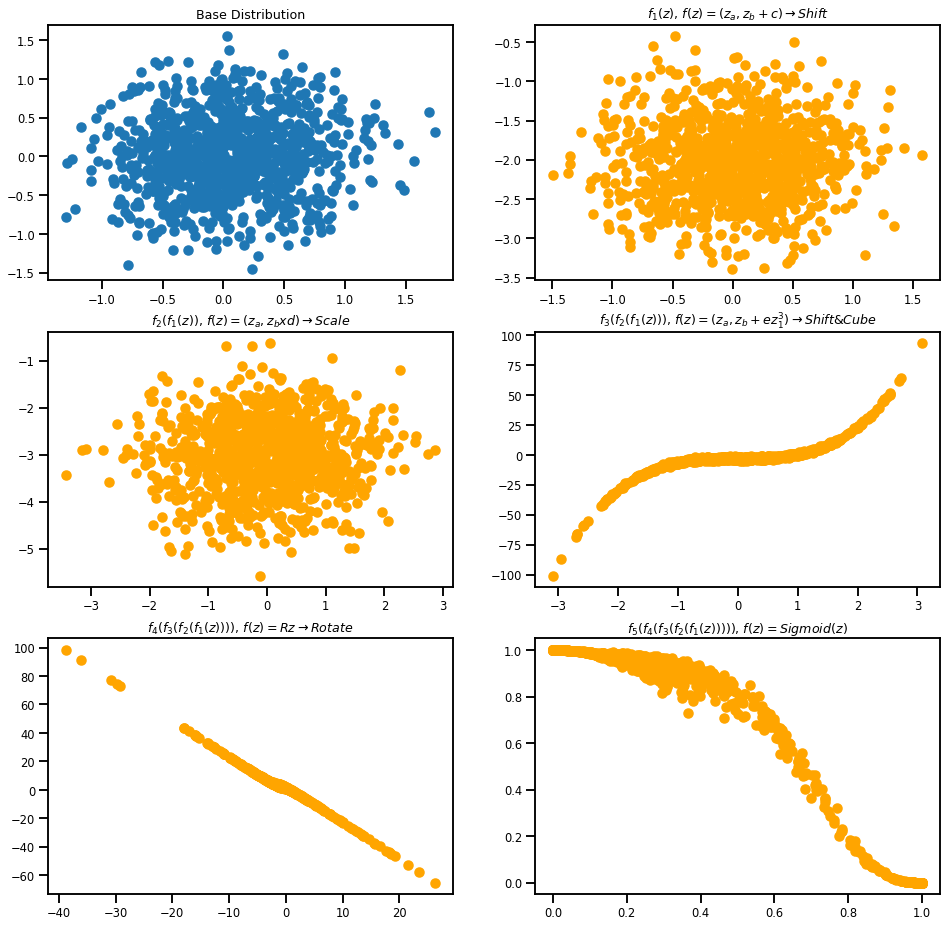

In [9]:
def plot_flow_densities(base_sample, base_dist, bijectors, names):
    _, axs = plt.subplots(3, 2, figsize=(16, 16))
    row = 0
    col = 0
    axs[row, col].scatter(base_sample[:, 0], base_sample[:, 1])
    axs[row, col].set_title("Base Distribution")
    col = 1
    function = 'z'
    func = 1
    for i in np.arange(1, 6):
        transformed_dist = create_transformed_distribution(base_dist, bijectors[0:i])
        img = transformed_dist.sample(1000)
        ax = axs[row, col]
        ax.scatter(img[:,0], img[:,1], color="orange")
        
       
        function = f'f_{func}({function})'
        ax.set_title(f'${function}$, {names[i-1]}')
        func += 1
        if(i % 2 == 1):
            row += 1
            col = 0
        else:
            col = 1
    plt.show()
    
plot_flow_densities(gaussian_2d_samples, gaussian_2d_base_dist, bijectors, names)


## Answers

### Distributions in Tensorflow-probability

In [20]:
S          = normal.sample([128,128,3])
print(S[:3,:3,0])
S_log_prob = normal.log_prob(S)
print(S_log_prob[:3,:3,0])
KL_n1_n2   = normal.kl_divergence(tfd.Normal(loc=1.0 , scale=2.0))
print(KL_n1_n2)


tf.Tensor(
[[ 0.84538305 -1.0602015  -0.42959327]
 [-1.4264888  -0.2674294  -0.27609724]
 [ 0.35027036 -1.0539948  -1.1951798 ]], shape=(3, 3), dtype=float32)
tf.Tensor(
[[-1.2762748  -1.4809521  -1.0112137 ]
 [-1.9363736  -0.9546978  -0.95705336]
 [-0.9802832  -1.474391   -1.6331658 ]], shape=(3, 3), dtype=float32)
tf.Tensor(0.44314718, shape=(), dtype=float32)


In [23]:
normal.kl_divergence(gamma)

NotImplementedError: ignored

In [27]:
approx_kl(normal,gamma)

<tf.Tensor: shape=(), dtype=float32, numpy=-1.4136546>

### Bijectors

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


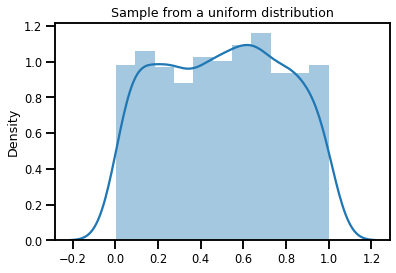

In [36]:
U = normal_cdf(normal)
U_s = U.sample(1000)
sns.distplot(U_s)
plt.title("Sample from a uniform distribution")
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


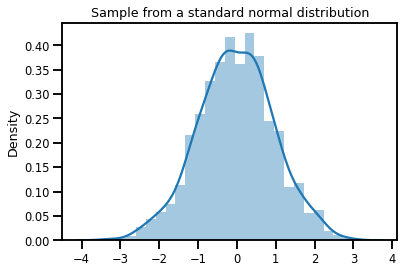

In [40]:
normal_qf = normal_cdf.inverse
unif      = tfd.Uniform(low=0.0,
    high=1.0)
U_s       = unif.sample(1000)
N_s         = normal_qf(U_s)
sns.distplot(N_s)
plt.title("Sample from a standard normal distribution")
plt.show()

### Learnable distributions

$\mu$ and $\sigma$ both simple functions of x

In [54]:
# Build model.
model = tf.keras.Sequential([
  tf.keras.layers.Dense(1 + 1),
  tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],
                           scale=1e-3 + tf.math.softplus(0.05 * t[...,1:]))),
])

# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=neg_log_likelihood)
model.fit(x, y, epochs=1000, verbose=False);

# Print weight and bias
[print(np.squeeze(w.numpy())) for w in model.weights];
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)


[0.12406649 0.9911447 ]
[ 5.209398 11.689734]


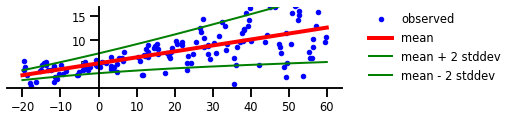

In [55]:
plt.figure(figsize=[6, 1.5])  # inches
plt.plot(x, y, 'b.', label='observed');

m = yhat.mean()
s = yhat.stddev()

plt.plot(x_tst, m, 'r', linewidth=4, label='mean');
plt.plot(x_tst, m + 2 * s, 'g', linewidth=2, label=r'mean + 2 stddev');
plt.plot(x_tst, m - 2 * s, 'g', linewidth=2, label=r'mean - 2 stddev');

plt.ylim(-0.,17);
plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));

ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['left'].set_smart_bounds(True)
#ax.spines['bottom'].set_smart_bounds(True)
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

plt.savefig('/tmp/fig2.png', bbox_inches='tight', dpi=300)


Output a Generalized Normal distribution with learnable mean, standard deviation and power.

In [57]:
# Build model.
model = tf.keras.Sequential([
  tf.keras.layers.Dense(1 + 1 + 1),
  tfp.layers.DistributionLambda(
      lambda t: tfd.GeneralizedNormal(loc=t[..., 0],
                           scale=1e-3 + tf.math.softplus(0.05 * t[...,1]),
                           power = 1. + tf.math.softplus(0.05 * t[...,2]))),
])

# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=neg_log_likelihood)
model.fit(x, y, epochs=1000, verbose=False);

# Print weight and bias
[print(np.squeeze(w.numpy())) for w in model.weights];
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)


[0.12400828 1.5554719  0.60402787]
[ 5.2401     5.6894007 -2.3391707]


Introducing the Dense Variational layer.

In [60]:
# Specify the posterior
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  c = np.log(np.expm1(1.))
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
  ])


In [62]:
# Build model.
model = tf.keras.Sequential([
  tfp.layers.DenseVariational(1, posterior_mean_field, prior_trainable, kl_weight=1/x.shape[0]),
  tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)),
])

# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=neg_log_likelihood)
model.fit(x, y, epochs=1000, verbose=False);

# Print weights
[print(np.squeeze(w.numpy())) for w in model.weights];
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)


[ 0.13207032  5.129863   -4.053582   -2.2188036 ]
[0.12517369 5.1556664 ]


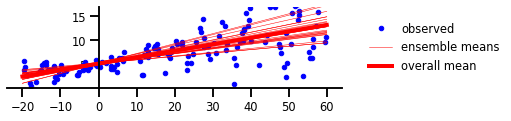

In [63]:
plt.figure(figsize=[6, 1.5])  # inches
plt.clf();
plt.plot(x, y, 'b.', label='observed');

yhats = [model(x_tst) for _ in range(100)]
avgm = np.zeros_like(x_tst[..., 0])
for i, yhat in enumerate(yhats):
  m = np.squeeze(yhat.mean())
  s = np.squeeze(yhat.stddev())
  if i < 25:
    plt.plot(x_tst, m, 'r', label='ensemble means' if i == 0 else None, linewidth=0.5)
  avgm += m
plt.plot(x_tst, avgm/len(yhats), 'r', label='overall mean', linewidth=4)

plt.ylim(-0.,17);
plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));

ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['left'].set_smart_bounds(True)
#ax.spines['bottom'].set_smart_bounds(True)
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))


### VAE



Designing a $\beta$-VAE

In [165]:
class Beta_Encoder(tfk.Model):
    
    def __init__(self):      
        super(Beta_Encoder,self).__init__()
        self.encoded_size = 2
        self.beta         = 0.5
        self.prior        = tfd.Independent(tfd.Normal(loc=tf.zeros(self.encoded_size), scale=1),
                        reinterpreted_batch_ndims=1)
        self.dense1       = tfkl.Dense(5,activation='relu')
        self.dense2       = tfkl.Dense(5,activation='relu')
        self.lambda1      = tfkl.Lambda(lambda x: tf.abs(x)+0.001)
        self.dense3       = tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(self.encoded_size))
        self.multv_norm1  = tfpl.MultivariateNormalTriL(self.encoded_size,
                                                   activity_regularizer=tfpl.KLDivergenceRegularizer(self.prior,
                                                                                                     weight=self.beta))
        
    def call(self, inputs):
      x = self.dense1(inputs)
      x = self.dense2(x)
      x = self.lambda1(x)
      x = self.dense3(x)
      x = self.multv_norm1(x)
      return x
      
class Beta_VAE(tfk.Model):
  def __init__(self):      
        super(Beta_VAE,self).__init__()
        self.beta_encoder = Beta_Encoder()
        self.beta_decoder = Decoder()
    
  def call(self,inputs):
    return self.beta_decoder(self.beta_encoder(inputs))
    


In [166]:
b_vae = Beta_VAE()

In [167]:
b_vae.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3),
            loss=neg_log_likelihood)
b_vae.fit(Ds,Ds,
        batch_size=32,
        epochs=100,
        verbose =1 
        )

Epoch 1/100
5/5 [==============================] - 5s 9ms/step - loss: 3.9488
Epoch 2/100
5/5 [==============================] - 0s 7ms/step - loss: 3.5981
Epoch 3/100
5/5 [==============================] - 0s 6ms/step - loss: 3.4666
Epoch 4/100
5/5 [==============================] - 0s 6ms/step - loss: 3.2164
Epoch 5/100
5/5 [==============================] - 0s 7ms/step - loss: 2.9073
Epoch 6/100
5/5 [==============================] - 0s 6ms/step - loss: 3.2586
Epoch 7/100
5/5 [==============================] - 0s 5ms/step - loss: 3.0504
Epoch 8/100
5/5 [==============================] - 0s 8ms/step - loss: 2.7779
Epoch 9/100
5/5 [==============================] - 0s 5ms/step - loss: 2.8113
Epoch 10/100
5/5 [==============================] - 0s 7ms/step - loss: 2.7701
Epoch 11/100
5/5 [==============================] - 0s 6ms/step - loss: 2.5911
Epoch 12/100
5/5 [==============================] - 0s 6ms/step - loss: 2.6591
Epoch 13/100
5/5 [==============================] - 0s 6ms/st

Learnable $\sigma$ in the prior

In [238]:
class Sig_Encoder(tfk.Model):
    
    def __init__(self):      
        super(Sig_Encoder,self).__init__()
        self.encoded_size = 2
        self.c            = tf.Variable(tf.random.uniform([1], minval=1,maxval = 2, dtype=tf.float32))
        self.prior        = self.make_mvn_prior(1,True)
        self.dense1       = tfkl.Dense(5,activation='relu')
        self.dense2       = tfkl.Dense(5,activation='relu')
        self.lambda1      = tfkl.Lambda(lambda x: tf.abs(x)+0.001)
        self.dense3       = tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(self.encoded_size))
        self.multv_norm1  = tfpl.MultivariateNormalTriL(self.encoded_size,
                                                   activity_regularizer=tfpl.KLDivergenceRegularizer(self.prior,
                                                                                                     weight=1.0, use_exact_kl = True))
    def make_mvn_prior(self,ndim,trainable):       
        if trainable:
            c = tf.Variable(tf.random.uniform([ndim], minval=1,maxval = 2, dtype=tf.float32), name='prior_c')
            m = tf.zeros(self.encoded_size)  
        prior = tfd.MultivariateNormalDiag(loc= m ,
                                           scale_identity_multiplier = c)
        return prior

    def call(self, inputs):
      x = self.dense1(inputs)
      x = self.dense2(x)
      x = self.lambda1(x)
      x = self.dense3(x)
      x = self.multv_norm1(x)
      return x


class Sig_VAE(tfk.Model):
  def __init__(self):      
        super(Sig_VAE,self).__init__()
        self.encoder = Sig_Encoder()
        self.decoder = Decoder()
    
  def call(self,inputs):
    return self.decoder(self.encoder(inputs))
    

In [239]:
s_vae = Sig_VAE()
print(s_vae.encoder.prior.parameters['scale_identity_multiplier'].numpy().tolist())

[1.2250590324401855]


In [240]:
class MyCustomCallback(tfk.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        print(f"Learned sigma for the prior {self.model.encoder.prior.parameters['scale_identity_multiplier'].numpy().tolist()}")

In [241]:
s_vae.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3),
            loss=neg_log_likelihood)

s_vae.fit(Ds,Ds,
        batch_size=32,
        epochs=100,
        verbose =1,
        callbacks=[MyCustomCallback()] 
        )

Learned sigma for the prior [1.2250590324401855]
Epoch 1/100


5/5 [==============================] - 4s 6ms/step - loss: 3.8432
Learned sigma for the prior [1.220061182975769]
Epoch 2/100
5/5 [==============================] - 0s 5ms/step - loss: 3.7635
Learned sigma for the prior [1.2150717973709106]
Epoch 3/100
5/5 [==============================] - 0s 4ms/step - loss: 3.8198
Learned sigma for the prior [1.2100956439971924]
Epoch 4/100
5/5 [==============================] - 0s 5ms/step - loss: 3.6153
Learned sigma for the prior [1.2051451206207275]
Epoch 5/100
5/5 [==============================] - 0s 4ms/step - loss: 3.3990
Learned sigma for the prior [1.2002246379852295]
Epoch 6/100
5/5 [==============================] - 0s 4ms/step - loss: 3.3815
Learned sigma for the prior [1.1953470706939697]
Epoch 7/100
5/5 [==============================] - 0s 4ms/step - loss: 3.2939
Learned sigma for the prior [1.1905101537704468]
Epoch 8/100
5/5 [==============================] - 0s 5ms/step - loss: 3.2164
Learned sigma for the prior [1.185713171958923

## Resources and references
[1] https://www.tensorflow.org/probability  
[2] https://gowrishankar.info/blog/normalizing-flows-a-practical-guide-using-tensorflow-probability/  
[3] Kingma, D. P., & Welling, M. (2013). Auto-encoding variational bayes.  
[4] Higgins, I., Matthey, L., Pal, A., Burgess, C., Glorot, X., Botvinick, M., ... & Lerchner, A. (2016). beta-vae: Learning basic visual concepts with a constrained variational framework.  
[5] Sullivan, T. J. (2015). Introduction to uncertainty quantification (Vol. 63). Springer.  
[6] Rippel, O., & Adams, R. P. (2013). High-dimensional probability estimation with deep density models. arXiv preprint arXiv:1302.5125.
